# 3-channel Autocorr with Tensorflow

In [4]:
import tensorflow as tf
import numpy as np
import torch
def torch_autocorr(x):
    if len(x.shape) < 4:
        x = torch.unsqueeze(x, dim=0)

    x = x.detach().cpu().numpy()

    dim = x.shape[1]

    x = 2*x - 1
    x = tf.transpose(x, perm=[0, 3, 1, 2])
    x = tf.cast(x, tf.complex64)

    m = x
    M = np.array(tf.signal.fft2d(m))

    mag = tf.math.abs(M)
    mag = tf.cast(mag, tf.complex64)

    ang = tf.math.atan2(tf.math.imag(M), tf.math.real(M))
    ang = tf.cast(ang, tf.complex64)

    exp1 = tf.math.exp(tf.dtypes.complex(0., -1.)*ang)
    exp2 = tf.math.exp(tf.dtypes.complex(0., 1.)*ang)

    term1 = mag*exp1
    term2 = mag*exp2

    FFtmp = (term1*term2)/(32**2)

    autocorr = tf.signal.ifft2d(FFtmp)
    autocorr = tf.math.real(autocorr)

    autocorr = tf.transpose(autocorr, perm=[0, 2, 3, 1])

    rv = np.int32(np.floor(dim/2))
    #rv = tf.cast(tf.math.floor(dim/2), tf.int32)
    # autocorr = tf.roll(autocorr, rv, 1)
    autocorr = tf.roll(autocorr, rv, 2)
    # # autocorr = tf.signal.ifftshift(autocorr, axes=(1, 2))


    # # Convert the TensorFlow tensor to a NumPy array
    # np_array = autocorr.numpy()
    np_array = autocorr.numpy()
    # Create a PyTorch tensor from the NumPy array
    torch_tensor_autocorr = torch.from_numpy(np_array)

    return torch_tensor_autocorr

# 3-channel Autocorr with PyTorch

In [5]:
import torch
import torch.nn as nn

def autocorr(x):
    """
    x is a 3 dimensional torch tensor.
    """
    if len(x.shape) < 4:
        x = torch.unsqueeze(x, dim=0)

    dim = x.shape[1]

    x = 2*x - 1
    x = torch.permute(x, (0, 3, 1, 2))
    x_complex = x.type(torch.complex64)

    M = torch.fft.fft2(x_complex)
    mag_M_complex = torch.abs(M).type(torch.complex64)

    # bug here: #RuntimeError: Function 'Atan2Backward0' returned nan values in its 0th output.
    # diagnosis: M.real becomes 0 which leads to NaN values into atan2
    # short-fix: add eps value to M.real
    eps=1e-6
    # TODO: is M.real negative anywhere?
    ang = torch.atan2(M.imag, M.real+eps)


    ang = ang.type(torch.complex64)

    device = ang.device
    # device = ang.get_device() # device used to be this
    exp1 = torch.exp(torch.complex(torch.tensor([0], dtype=torch.float32, device=device), torch.tensor([-1], dtype=torch.float32, device=device))*ang)
    exp2 = torch.exp(torch.complex(torch.tensor([0], dtype=torch.float32, device=device), torch.tensor([1], dtype=torch.float32, device=device))*ang)

    term1 = mag_M_complex*exp1
    term2 = mag_M_complex*exp2

    FFtmp = (term1*term2) / (32**2)

    autocorr = torch.fft.ifft2(FFtmp) # till here the values are the same upto 1e-7 tolerance
    autocorr = autocorr.real
    autocorr = torch.permute(autocorr, (0, 2, 3, 1))

    rv = torch.tensor(dim//2, dtype=torch.int32)
    # #autocorr = torch.roll(autocorr, rv, 1)
    # #autocorr = torch.roll(autocorr, rv, 2)
    autocorr = torch.roll(autocorr, dim//2, 2)
    # return autocorr

    return autocorr

## Test that the outputs from the tensorflow implementation and the pytorch implementation are the same.

In [6]:
test_input = torch.randn((3, 64, 64))
tolerance = 1e-06
def equal_within_tolerance(arr1, arr2, ):
    return np.isclose(arr1.numpy(), arr2.numpy(),
                      atol=tolerance
                      )

In [7]:
output1 = torch_autocorr(test_input)
output2 = autocorr(test_input)
print(output1.shape)
print(output2.shape)
print(f"All values equal: {(output1==output2).all()}")
print(equal_within_tolerance(output1, output2))
print(f"All values within the tolerance of {tolerance}: {equal_within_tolerance(output1, output2).all()}")
print(f"{np.sum((equal_within_tolerance(output1, output2))==True)} values within the tolerance value of {tolerance}.")
print(f"{np.sum((equal_within_tolerance(output1, output2))==False)} not values within the tolerance value {tolerance}.")

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
All values equal: False
[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]]]
All values within the tolerance of 1e-06: True
12288 values within the tolerance val

## 3-channel Autocorr Loss Definition

In [8]:
class FFTLoss(nn.Module):
    def __init__(self):
        super(FFTLoss, self).__init__()
        self.mae_loss = nn.L1Loss()

    def forward(self, input, target):
        input_autocorr = autocorr(input)
        target_autocorr = autocorr(target)
        diff = self.mae_loss(input_autocorr, target_autocorr)
        return diff

In [9]:
# test the loss
import torch
import torch.nn as nn

input = torch.randn((3, 64, 64), requires_grad=True)
target = torch.randn((3, 64, 64))

mae_loss = nn.L1Loss()
output = mae_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[[ 1.5844,  2.3850, -0.7453,  ..., -1.6999,  0.0049, -0.6264],
         [-0.2737, -0.3076,  0.0788,  ..., -0.5635, -1.4234, -0.3916],
         [ 1.0593,  0.5306,  0.2403,  ...,  0.3872,  1.0334, -0.0484],
         ...,
         [ 0.1068,  0.3477,  0.0632,  ...,  2.2598, -0.1183,  0.1464],
         [ 0.4537, -0.9752, -1.4914,  ..., -0.3401, -0.9664, -0.6865],
         [-1.2258, -0.6782,  0.7325,  ...,  1.3614,  1.6083,  1.1866]],

        [[ 0.8961,  0.4742,  0.4697,  ..., -0.6587, -0.1944, -0.8582],
         [-1.5639,  1.5904,  1.3730,  ..., -1.0751, -1.3736, -2.2031],
         [ 0.0995,  0.0772,  0.2394,  ..., -1.6253,  0.3708,  0.2671],
         ...,
         [-0.6089,  0.4885,  0.5964,  ...,  0.4846, -0.2461,  0.7501],
         [-0.4174, -1.0292, -0.7209,  ...,  1.3391, -2.9967,  1.9490],
         [ 0.5829, -1.3463,  1.2110,  ..., -0.2027, -1.2969, -1.3199]],

        [[-0.6086,  0.3795,  0.6482,  ...,  0.4441,  0.2197, -0.3794],
         [-0.2895,  0.7276, -0.4329, 

In [10]:
# test the loss
import torch
import torch.nn as nn

input = torch.randn((3, 64, 64), requires_grad=True)
target = torch.randn((3, 64, 64))

fft_loss = FFTLoss()
output = fft_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[[ 0.0632,  0.5703,  0.5042,  ..., -1.4366,  1.5217, -0.7888],
         [ 1.0409,  1.3789,  0.5409,  ..., -0.4922,  0.4792,  0.1041],
         [ 0.0577,  0.4637,  0.7188,  ...,  0.2890,  1.4146, -0.6688],
         ...,
         [ 0.6111, -2.0971,  0.5029,  ...,  2.7713, -1.2546, -1.3935],
         [-0.5656,  1.1384, -0.0472,  ...,  0.8142, -0.7272,  0.2222],
         [-0.1634, -0.3970, -1.0336,  ...,  0.9261,  0.7451, -0.5798]],

        [[-0.7923, -0.0243, -1.2573,  ..., -0.1772, -1.6246,  0.6305],
         [ 0.3310, -0.2264, -1.6536,  ...,  1.6238,  1.9152,  0.5095],
         [ 0.3703,  1.2908,  0.7102,  ...,  0.5952, -0.2070, -0.5702],
         ...,
         [ 1.2992,  0.5883,  0.3004,  ..., -1.3658, -0.6788,  0.0871],
         [-0.0846, -0.2618,  0.4455,  ..., -1.3941, -0.0100,  0.8696],
         [ 0.5937,  1.8452, -0.0137,  ..., -0.4370,  1.4704,  1.1056]],

        [[ 0.5505, -0.8911, -0.5091,  ..., -1.1053,  1.6671,  0.4825],
         [ 0.9111, -0.2574, -0.1010, 

# Autocorr for Binarized Images

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<ipython-input-11-ed705a678eab>:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
<ipython-input-11-ed705a678eab>:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [12]:
el = 224  # number of elements per side in the microstructure
H = 2  # number of phases in the microstructure
vf = .4  # volume fraction of phase 0
iA = 0  # phase A of correlation
iB = 0  # phase B of correlation

## Generate microstructure

In [6]:
def generate_microstructure(el):
    base = np.random.random((el, el))

    r2a = np.random.randint(2, 20)
    r2b = np.random.randint(2, 20)
    weights = np.random.random(size=(r2a, r2b))

    raw = convolve(base, weights, mode='wrap')

    blur = gaussian_filter(raw, sigma=1)

    amin = blur.min()
    amax = blur.max()
    scaled = (blur-amin)/(amax-amin)

    micr = scaled > vf
    return micr
micr = generate_microstructure(el)

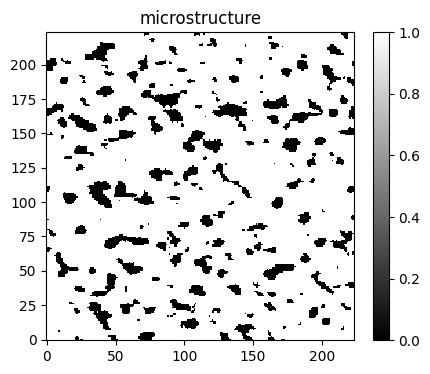

In [7]:
plt.figure(figsize=[5, 4])
ax = plt.imshow(micr, origin='lower',
                interpolation='none', cmap='gray')
plt.colorbar(ax)
plt.title('microstructure')
plt.show()

In [15]:
# el = res_size  # number of elements per side in the microstructure
# H = 2  # number of phases in the microstructure
# vf = .4  # volume fraction of phase 0
# iA = 0  # phase A of correlation
# iB = 0  # phase B of correlation

In [16]:
def generate_microstructure_function(micr, H, el):
    """
    Inputs:
    micr: microstructure image (np array)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    np array microstructure function
    """
    mf = np.zeros((H, el, el))
    for h in range(H):
        mf[h, ...] = micr[...] == h
    frac = np.sum(mf[0, ...])/np.float32(mf[0, ...].size)
    print("volume fraction phase 0: %s" % np.round(frac, 2))
    return mf

In [17]:
def cal_2p_spst(mf, H, el):
    st = time.time()

    M = np.zeros((H, el, el), dtype='complex128')

    for h in range(H):
        M[h, ...] = np.fft.fftn(mf[h, ...], axes=[0, 1])

    S = el**2

    M1 = M[iA, ...]
    mag1 = np.abs(M1)
    ang1 = np.arctan2(M1.imag, M1.real)
    exp1 = np.exp(-1j*ang1)
    term1 = mag1*exp1

    M2 = M[iB, ...]
    mag2 = np.abs(M2)
    ang2 = np.arctan2(M2.imag, M2.real)
    exp2 = np.exp(1j*ang2)
    term2 = mag2*exp2

    FFtmp = term1*term2/S

    ff_v2 = np.fft.ifftn(FFtmp, [el, el], [0, 1]).real

    timeT = np.round(time.time()-st, 5)
    print("correlation computed: %s s" % timeT)
    return ff_v2

## PyTorch Implementation

In [18]:
import torch
import torch.nn as nn

### Implement the microstruction function in PyTorch

In [19]:
def generate_torch_microstructure_function(micr, H, el):
    """
    Inputs:
    micr: microstructure image (torch.Tensor)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    torch.Tensor microstructure function
    """
    mf = torch.zeros((H, el, el), device=micr.device, requires_grad=True)
    with torch.no_grad():
        for h in range(H):
            mf[h, ...] = micr.eq(h).clone().detach().to(micr.device)
    frac = torch.sum(mf[0, ...]).float() / mf[0, ...].numel()
    print("volume fraction phase 0: %s" % round(frac.item(), 2))
    return mf

#### Test that the PyTorch implementation of the mf is correct.

In [20]:
numpy_mf = generate_microstructure_function(micr, H, el)
torch_mf = generate_torch_microstructure_function(torch.tensor(micr), H, el)

volume fraction phase 0: 0.3
volume fraction phase 0: 0.3


In [21]:
test_input = torch.randn((3, 64, 64))
tolerance = 1e-06
def equal_within_tolerance(arr1, arr2, ):
    return np.isclose(arr1, arr2.detach().numpy(),
                      atol=tolerance
                      )

In [22]:
print(numpy_mf.shape)
print(torch_mf.shape)
print(f"All values equal: {(numpy_mf==torch_mf)}")
print(equal_within_tolerance(numpy_mf, torch_mf))
print(f"All values within the tolerance of {tolerance}: {equal_within_tolerance(numpy_mf, torch_mf).all()}")
print(f"{np.sum((equal_within_tolerance(numpy_mf, torch_mf))==True)} values within the tolerance value of {tolerance}.")
print(f"{np.sum((equal_within_tolerance(numpy_mf, torch_mf))==False)} not values within the tolerance value {tolerance}.")

(2, 224, 224)
torch.Size([2, 224, 224])
All values equal: False
[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]]
All values within the tolerance of 1e-06: True
100352 values within the tolerance value of 1e-06.
0 not values within the tolerance value 1e-06.


#### Test loss

In [23]:
class MSFunctionLoss(nn.Module):
    def __init__(self):
        super(MSFunctionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_msf = generate_torch_microstructure_function(input, H=2, el=input.shape[-1]).unsqueeze(dim=0)
        target_msf = generate_torch_microstructure_function(target, H=2, el=target.shape[-1]).unsqueeze(dim=0)
        diff = self.mse_loss(input_msf, target_msf)
        return diff

In [24]:
#input = torch.randn((1, 64, 64), requires_grad=True)
#target = torch.randn((1, 64, 64))

input = torch.tensor(generate_microstructure(el))
target = torch.tensor(generate_microstructure(el))
two_pt_fft_loss = MSFunctionLoss()
output = two_pt_fft_loss(input, target)
print("loss.item: ", output.item())
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

volume fraction phase 0: 0.15
volume fraction phase 0: 0.19
loss.item:  0.2931082546710968
input:  tensor([[False, False,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False]])
target:  tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
output:  tensor(0.2931, grad_fn=<MseLossBackward0>)


### Create cal_2p_spst in PyTorch

In [25]:
def calculate_2point_torch_spatialstat(mf, H, el):
    """
    Inputs:
    mf: microstructure function torch.Tensor
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    ff_v2: 2d torch.Tensor FFT function
    """
    st = time.time()

    M = torch.zeros((H, el, el), dtype=torch.complex128, device=mf.device)

    for h in range(H):
        M[h, ...] = torch.fft.fftn(mf[h, ...], dim=[0, 1])

    S = el**2

    M1 = M[iA, ...]
    mag1 = torch.abs(M1)

    eps=1e-6
    ang1 = torch.arctan2(M1.imag, M1.real+eps)
    exp1 = torch.exp(-1j*ang1)
    term1 = mag1*exp1

    M2 = M[iB, ...]
    mag2 = torch.abs(M2)
    ang2 = torch.arctan2(M2.imag, M2.real+eps)
    exp2 = torch.exp(1j*ang2)
    term2 = mag2*exp2

    FFtmp = term1*term2/S

    ff_v2 = torch.fft.ifftn(FFtmp, [el, el], [0, 1]).real

    timeT = round(time.time()-st, 5)
    print("correlation computed: %s s" % timeT)
    return ff_v2

In [26]:
numpy_ff = cal_2p_spst(numpy_mf, H, el)
torch_ff = calculate_2point_torch_spatialstat(torch_mf, H, el)

correlation computed: 0.02109 s
correlation computed: 0.04273 s


#### Test that the PyTorch implementation is valid.

In [27]:
print(numpy_ff.shape)
print(torch_ff.shape)
print(f"All values equal: {(numpy_ff==torch_ff)}")
print(equal_within_tolerance(numpy_ff, torch_ff))
print(f"All values within the tolerance of {tolerance}: {equal_within_tolerance(numpy_ff, torch_ff).all()}")
print(f"{np.sum((equal_within_tolerance(numpy_ff, torch_ff))==True)} values within the tolerance value of {tolerance}.")
print(f"{np.sum((equal_within_tolerance(numpy_ff, torch_ff))==False)} not values within the tolerance value {tolerance}.")

(224, 224)
torch.Size([224, 224])
All values equal: False
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
All values within the tolerance of 1e-06: True
50176 values within the tolerance value of 1e-06.
0 not values within the tolerance value 1e-06.


In [28]:
def two_point_autocorr_pytorch(img, H=2):
    """
    PyTorch Implementation of 2-pt Spatial Statistics: FFT Approach.
    img: torch.Tensor (shape 1 x H x W) H=W
    H: number of phases in the microstructure (int)

    returns:
    torch.Tensor of size H x W
    """
    el = img.size()[-1]
    microstructure = img.squeeze(dim=0)
    mf = generate_torch_microstructure_function(microstructure, H, el)
    fft = calculate_2point_torch_spatialstat(mf, H, el)
    return fft

In [29]:
def show_spst(arr1, title, arr2=None, title2=None):
    # arr1 and arr2 are numpy arrays of size [H, W]

    plt.figure(figsize=[11, 4])

    plt.subplot(121)
    ff_c = np.fft.fftshift(arr1)
    x_values = np.arange(-ff_c.shape[1] // 2, ff_c.shape[1] // 2)
    y_values = np.arange(-ff_c.shape[0] // 2, ff_c.shape[0] // 2)
    ax = plt.imshow(ff_c, origin='lower',
                    interpolation='none', cmap='gray', extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])

    plt.colorbar(ax)
    plt.title(f'Correlation ({title}): %s and %s' % (iA, iB))

    if title2 != None:
        plt.subplot(122)
        ff_c = np.fft.fftshift(arr2)
        x_values = np.arange(-ff_c.shape[1] // 2, ff_c.shape[1] // 2)
        y_values = np.arange(-ff_c.shape[0] // 2, ff_c.shape[0] // 2)
        ax = plt.imshow(ff_c, origin='lower',
                        interpolation='none', cmap='gray', extent=[x_values[0], x_values[-1], y_values[0], y_values[-1]])
        plt.colorbar(ax)
        plt.title(f'Correlation ({title2}): %s and %s' % (iA, iB))


    plt.show()

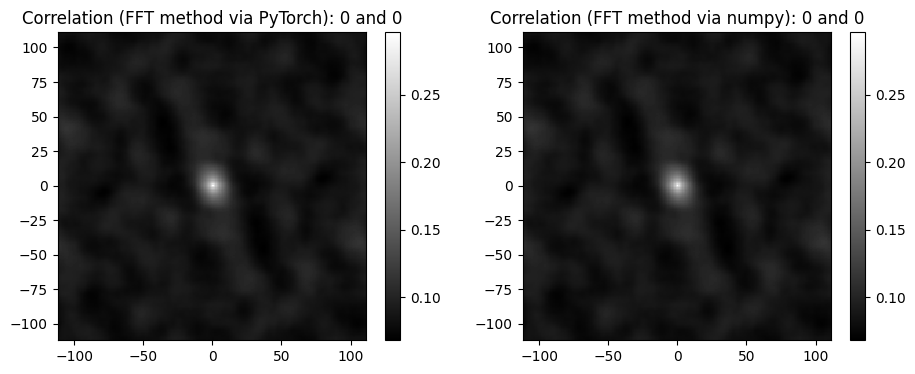

In [30]:
show_spst(torch_ff.detach().numpy(), title='FFT method via PyTorch', arr2=numpy_ff, title2='FFT method via numpy')

## Implement PyTorch Loss function

In [31]:
class TwoPointFFTLoss(nn.Module):
    def __init__(self):
        super(TwoPointFFTLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_autocorr = two_point_autocorr_pytorch(input).unsqueeze(dim=0)
        target_autocorr = two_point_autocorr_pytorch(target).unsqueeze(dim=0)
        print(input_autocorr.shape)
        diff = self.mse_loss(input_autocorr, target_autocorr)
        #diff = self.mse_loss(input, target)
        print(diff)
        show_spst(input_autocorr[0].detach().numpy(), title='input', arr2=target_autocorr[0].detach().numpy(), title2='target')
        return diff

### Test the loss function

volume fraction phase 0: 0.19
correlation computed: 0.02072 s
volume fraction phase 0: 0.18
correlation computed: 0.02184 s
torch.Size([1, 224, 224])
tensor(4.3519e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)


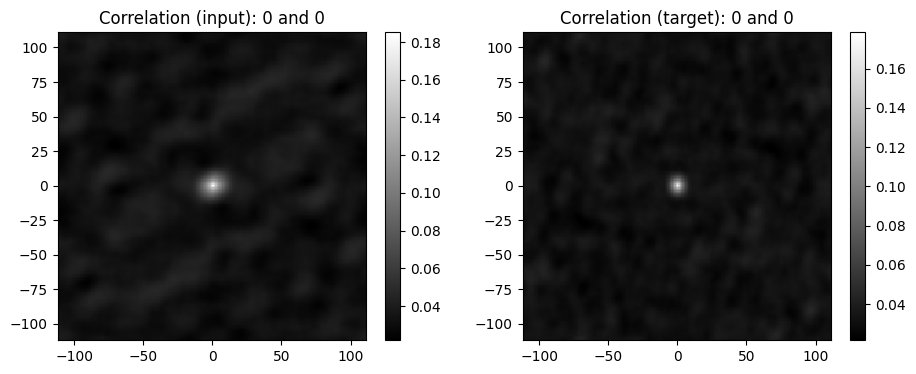

loss.item:  4.351918442209101e-05
input:  tensor([[ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])
target:  tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
output:  tensor(4.3519e-05, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [32]:
#input = torch.randn((1, 64, 64), requires_grad=True)
#target = torch.randn((1, 64, 64))

input = torch.tensor(generate_microstructure(el))
target = torch.tensor(generate_microstructure(el))
two_pt_fft_loss = TwoPointFFTLoss()
output = two_pt_fft_loss(input, target)
print("loss.item: ", output.item())
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

## Implement the above code for batches of images

In [3]:
import torch
import torch.nn as nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import time

<ipython-input-3-2ebbfad8d0e8>:9: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve
<ipython-input-3-2ebbfad8d0e8>:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [41]:
el = 224  # number of elements per side in the microstructure
H = 2  # number of phases in the microstructure
vf = .4  # volume fraction of phase 0
iA = 0  # phase A of correlation
iB = 0  # phase B of correlation

def generate_torch_microstructure_function(micr, H, el):
    """
    Inputs:
    micr: microstructure image (torch.Tensor) of shape W x H
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    torch.Tensor microstructure function
    """
    mf = torch.zeros((H, el, el), device=micr.device, requires_grad=True)
    with torch.no_grad():
        for h in range(H):
            mf[h, ...] = micr.eq(h).clone().detach().to(micr.device)
    #frac = torch.sum(mf[0, ...]).float() / mf[0, ...].numel()
    #print("volume fraction phase 0: %s" % round(frac.item(), 2))
    return mf


def calculate_2point_torch_spatialstat(mf, H, el):
    """
    Inputs:
    mf: microstructure function torch.Tensor (el x el)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)

    returns:
    ff_v2: 2d torch.Tensor FFT function
    """
    #st = time.time()

    M = torch.zeros((H, el, el), dtype=torch.complex128, device=mf.device)
    for h in range(H):
        M[h, ...] = torch.fft.fftn(mf[h, ...], dim=[0, 1])

    S = el**2

    M1 = M[iA, ...]
    mag1 = torch.abs(M1)

    eps=1e-6
    ang1 = torch.arctan2(M1.imag, M1.real+eps)
    exp1 = torch.exp(-1j*ang1)
    term1 = mag1*exp1

    M2 = M[iB, ...]
    mag2 = torch.abs(M2)
    ang2 = torch.arctan2(M2.imag, M2.real+eps)
    exp2 = torch.exp(1j*ang2)
    term2 = mag2*exp2

    FFtmp = term1*term2/S

    ff_v2 = torch.fft.ifftn(FFtmp, [el, el], [0, 1]).real

    #timeT = round(time.time()-st, 5)
    #print("correlation computed: %s s" % timeT)
    return ff_v2


def calculate_batch_2point_torch_spatialstat(mfs, H, el):
    """
    calculates spatial stats for a batch of microstructure functions
    mfs: microstructure function torch.Tensor (batch_size x el x el)
    H: number of phases in the microstructure (int)
    el: length of micr along one dimension in pixels (int)
    """
    return torch.concat([calculate_2point_torch_spatialstat(mf, H, el) for mf in mfs], dim=0)


def two_point_autocorr_pytorch(imgs, H=2):
    """
    PyTorch Implementation of 2-pt Spatial Statistics: FFT Approach.

    TODO: make this function take in batches

    img: torch.Tensor (shape batch_size x H x W) H=W
    H: number of phases in the microstructure (int)

    returns:
    torch.Tensor of size H x W
    """
    el = imgs.shape[-1]
    microstructure_functions = torch.concat([generate_torch_microstructure_function(img, H, el).unsqueeze(dim=0) for img in imgs], dim=0)
    ffts = calculate_batch_2point_torch_spatialstat(microstructure_functions, H, el)
    return ffts


class TwoPointFFTLoss(nn.Module):
    def __init__(self):
        super(TwoPointFFTLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target):
        input_autocorr = two_point_autocorr_pytorch(input)
        target_autocorr = two_point_autocorr_pytorch(target)
        diff = self.mse_loss(input_autocorr, target_autocorr)
        return diff

In [42]:
input1 = torch.tensor(generate_microstructure(el)).unsqueeze(dim=0)
input2 = torch.tensor(generate_microstructure(el)).unsqueeze(dim=0)
input = torch.cat([input1, input2], dim=0)

target1 = torch.tensor(generate_microstructure(el)).unsqueeze(dim=0)
target2 = torch.tensor(generate_microstructure(el)).unsqueeze(dim=0)
target = torch.cat([target1, target2], dim=0)

fft_loss = TwoPointFFTLoss()
loss = fft_loss(input, target)

In [43]:
print(loss)

tensor(0.0014, dtype=torch.float64, grad_fn=<MseLossBackward0>)
